Note: We used several Kaggle tutorials ([1](https://www.kaggle.com/leonzz/m5-forecasting-arima), [2](https://www.kaggle.com/tarunpaparaju/m5-competition-eda-models), [3](https://www.kaggle.com/binhlc/forecasting-multiple-time-series-using-prophet)) in the course of writing this notebook for inspiration and pointers on which libraries and methods to use (like ExpSmoothing, Facebook Prophet, etc.). However, all the code here is written by us.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tqdm.notebook import tqdm as tqdm

# Preprocessing

In [2]:
calendar = pd.read_csv('../data/calendar.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
sales_train_validation = pd.read_csv('../data/sales_train_validation.csv')

In [330]:
sales_train_val_shuffled = sales_train_validation.sample(frac=0.001)
sales_data = sales_train_val_shuffled.iloc[:, 6:]

sales_train_set = sales_data.iloc[:,-28*3:-28]
sales_val_set = sales_data.iloc[:,-28:]
sampled_item_ids = sales_val_set.sample(n=4).index.values
sales_train_set

,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,...,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885
29997,1,1,1,1,1,2,3,1,1,1,...,1,1,2,1,3,0,0,0,1,0
9725,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,1,1,0
24233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20537,1,1,0,0,1,0,0,1,0,1,...,0,1,2,3,0,1,0,1,2,0
28681,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
28423,14,2,7,6,10,10,0,0,3,4,...,0,0,0,0,0,0,0,0,0,0
29455,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,2,0,1
5263,0,0,2,5,1,1,3,2,1,6,...,0,1,0,0,0,0,2,2,1,4
8431,2,1,0,10,4,0,0,0,0,5,...,5,1,0,1,4,6,1,7,6,6


# Models
## ARIMA

In [331]:
import warnings
warnings.filterwarnings("ignore")

In [332]:
def arima_order_selection(data, seasonal_order, max_p=3, max_d=1, max_q=3):
    aics = np.zeros((max_p, max_d, max_q))
    aics[:] = np.iinfo(np.int32).max
    for p in range(max_p):
        for d in range(max_d):
            for q in range(max_q):
                if p==0 and q==0 and d==0:
                    continue
                model = sm.tsa.statespace.SARIMAX(data, order=(p, d, q), seasonal_order=seasonal_order)
                try:
                    residual = model.fit()
                    aics[p, d, q] = residual.aic
                except:
                    continue
    best_order = np.unravel_index(np.argmin(aics), aics.shape)
    return best_order

In [333]:
def arima_fit_predict(train, val, seasonal_order, forecast_len=28):
    pred_train = pd.DataFrame(columns=train.columns, index=train.index)
    pred_forecast = pd.DataFrame(columns=val.columns, index=val.index)
    with tqdm(total=train.shape[0]) as pbar:
        for idx, data_item in train.iterrows():
            pred_order = arima_order_selection(data_item.values, seasonal_order)
            fit = sm.tsa.statespace.SARIMAX(data_item.values, order=pred_order, seasonal_order=seasonal_order).fit()
            pred_train.loc[idx, :] = fit.predict()
            pred_forecast.loc[idx, :] = fit.forecast(forecast_len)
            pbar.update(1)
    return pred_train, pred_forecast

In [334]:
def get_rmse(true, pred):
    errors = pred - true
    return np.sqrt(np.mean(errors.values ** 2))

def plot_four_item_pred(sampled_ids, true_train, pred_train, true_val, pred_val, figname):
    fig, axs = plt.subplots(2, 2)
    plt.tight_layout()
    plt.xlabel("Days")
    plt.ylabel("Quantity of Items Sold")
    fig.set_size_inches(12, 12)
    axs = np.reshape(axs, -1)
    i = 0
    n_items = true_train.shape[0]
    n_days_val = true_val.shape[1]
    for idx in sampled_ids:
        axs[i].set_xlabel("Days")
        axs[i].set_ylabel("Quantity sold of Item#{idx}".format(idx=idx))
        axs[i].plot(np.arange(n_days_val)+1, true_train.loc[idx, :].values[-n_days_val:], label='True Train', color='blue')
        axs[i].plot(np.arange(n_days_val)+1, pred_train.loc[idx, :].values[-n_days_val:], label='Pred. Train', color='red')
        axs[i].plot(np.arange(n_days_val)+n_days_val+1, true_val.loc[idx, :], label='True Validation', color='yellow', linestyle='-.')
        axs[i].plot(np.arange(n_days_val)+n_days_val+1, pred_val.loc[idx, :], label='Pred. Validation', color='darkgreen', linestyle='--')
        axs[i].legend()
        i = i + 1
    plt.savefig("../doc/figures/forecast/{fname}.pdf".format(fname=figname))

## Exponential Smoothing
An alternative to the ARIMA model.

In [338]:
def exp_fit_predict(train, val, forecast_len=28):
    pred_train = pd.DataFrame(columns=train.columns, index=train.index)
    pred_forecast = pd.DataFrame(columns=val.columns, index=val.index)
    with tqdm(total=train.shape[0]) as pbar:
        for idx, data_item in train.iterrows():
            fit = ExponentialSmoothing(data_item.values, seasonal_periods=7,seasonal='add').fit()
            pred_train.loc[idx, :] = fit.predict(0,train.shape[1]-1)
            pred_forecast.loc[idx, :] = fit.forecast(forecast_len)
            pbar.update(1)
    return pred_train, pred_forecast

## Prophet
Prophet is a time series modelling toolkit from Facebook, we test it next.

In [341]:
# Prophet requires the dates, so we get them from the calendar..
days_val = sales_val_set.columns
dates_val = calendar.loc[calendar["d"].isin(days_val)]["date"]
days_train = sales_train_set.columns
dates_train = calendar.loc[calendar["d"].isin(days_train)]["date"]

In [342]:
def prophet_fit_predict(train, dates_train, val, dates_val, forecast_len=28):
    pred_train = pd.DataFrame(columns=train.columns, index=train.index)
    pred_forecast = pd.DataFrame(columns=val.columns, index=val.index)
    with tqdm(total=train.shape[0]) as pbar:
        for idx, data_item in train.iterrows():
            arr = np.zeros(shape=(train.shape[1], 2))
            temp = pd.DataFrame(arr)
            temp.columns = ["ds", "y"]
            temp.loc[:, "ds"] = dates_train.values
            temp.loc[:, "y"] = data_item.values
            model = Prophet(daily_seasonality=True,yearly_seasonality=False)
            model.fit(temp)
            forecast_period = model.make_future_dataframe(periods=28)
            forecast = model.predict(forecast_period)["yhat"].values
            pred_train.loc[idx, :] = forecast[:pred_train.shape[1]]  
            pred_forecast.loc[idx, :] = forecast[pred_train.shape[1]:]
            pbar.update(1)
    return pred_train, pred_forecast

# Item-Level Predictions
Here we apply the previous models to predict the results of individual items. Due to the large size of the dataset, we make heavy use of subsampling.

## ARIMA Item-Level

In [335]:
sales_pred_train, sales_pred_forecast = arima_fit_predict(sales_train_set, sales_val_set, (0, 1, 1, 7))

Test RMSE for SARIMAX is 1.955584300177456


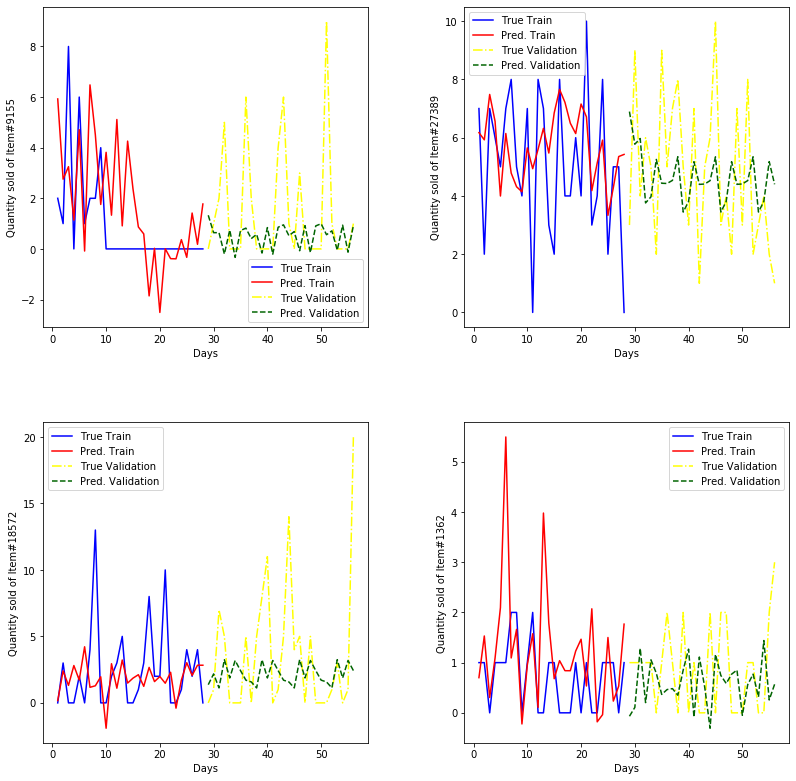

In [337]:
print("Test RMSE for SARIMAX is", get_rmse(sales_val_set, sales_pred_forecast))
plot_four_item_pred(sampled_item_ids, sales_train_set, sales_pred_train, sales_val_set, sales_pred_forecast, "sarimax_items")

## ExpSmoothing Item-Level

In [339]:
sales_pred_train_exp, sales_pred_val_exp = exp_fit_predict(sales_train_set, sales_val_set)

RMSE for ExpSmoothing is 1.9338280494471192


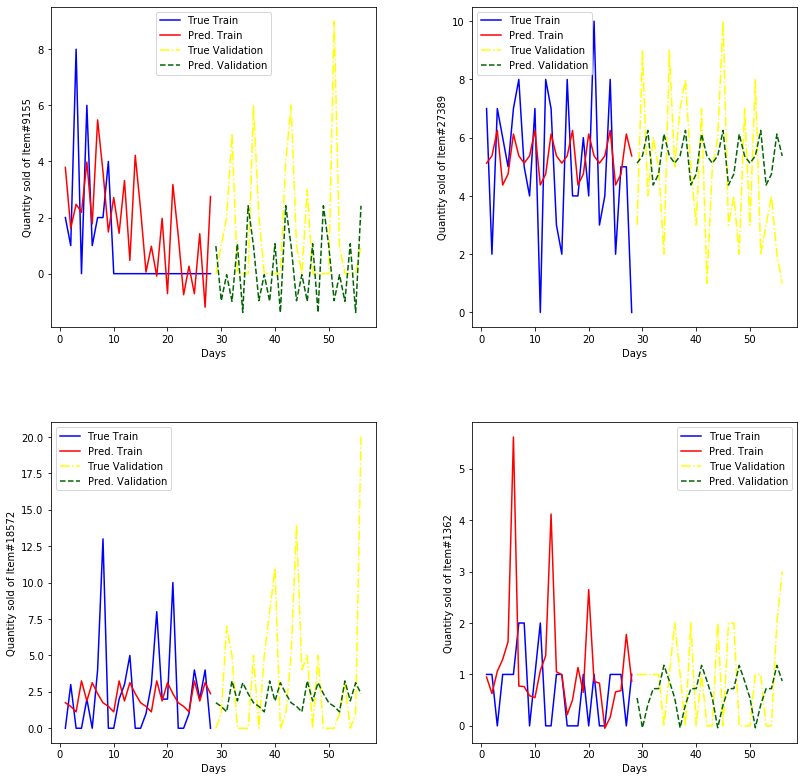

In [340]:
print("RMSE for ExpSmoothing is", get_rmse(sales_val_set, sales_pred_val_exp))
plot_four_item_pred(sampled_item_ids, sales_train_set, sales_pred_train_exp, sales_val_set, sales_pred_val_exp, "exp_sm_items")

## Prophet Item-Level

In [343]:
sales_pred_train_pro, sales_pred_val_pro = prophet_fit_predict(sales_train_set, dates_train, sales_val_set, dates_val)

RMSE for Prophet is 2.0887687633316454


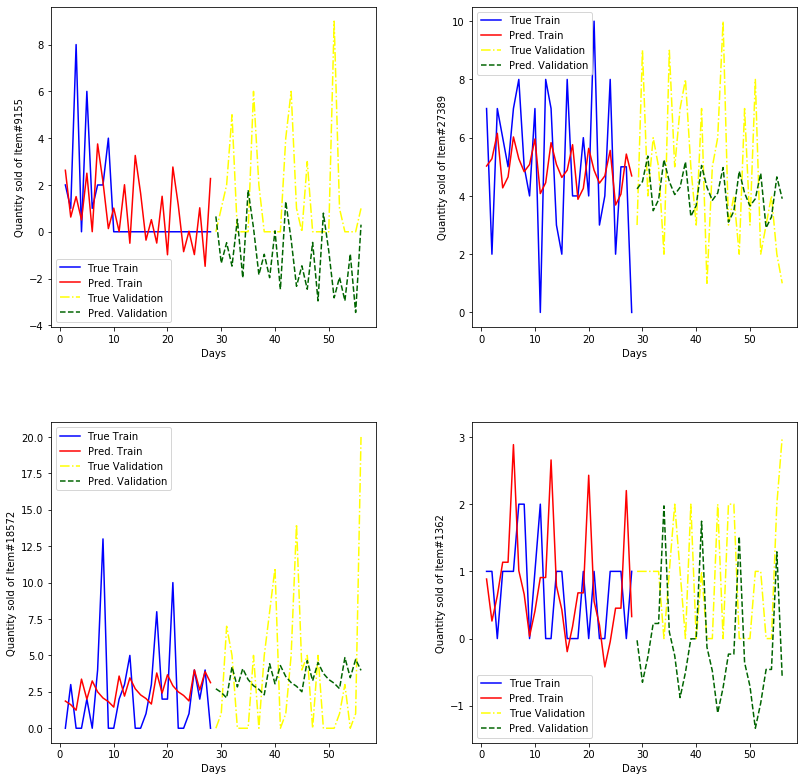

In [344]:
print("RMSE for Prophet is", get_rmse(sales_val_set, sales_pred_val_pro))
plot_four_item_pred(sampled_item_ids, sales_train_set, sales_pred_train_pro, sales_val_set, sales_pred_val_pro, "prophet_items")

# Category-Level Predictions

In [352]:
cat_sales = sales_train_val_shuffled.groupby("cat_id").sum()
cat_sales

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
cat_id,,,,,,,,,,,,,,,,,,,,,
FOODS,8,6,10,9,7,5,8,17,16,6,...,35,41,60,28,25,36,20,31,24,20
HOBBIES,1,2,1,15,2,2,2,1,1,2,...,1,7,2,1,10,3,4,1,3,25
HOUSEHOLD,4,4,0,2,1,2,0,2,6,1,...,5,5,3,3,2,3,1,3,2,3


In [358]:
cat_sales_train = cat_sales.iloc[:,:-28]
cat_sales_val = cat_sales.iloc[:,-28:]

In [369]:
def plot_three_item_pred(sampled_ids, true_train, pred_train, true_val, pred_val, figname):
    fig, axs = plt.subplots(3)
    plt.tight_layout()
    plt.xlabel("Days")
    plt.ylabel("Quantity of Items Sold")
    fig.set_size_inches(12, 12)
    axs = np.reshape(axs, -1)
    i = 0
    n_items = true_train.shape[0]
    n_days_val = true_val.shape[1]
    for idx in sampled_ids:
        axs[i].set_title(idx)
        axs[i].set_xlabel("Days")
        axs[i].set_ylabel("Quantity sold of Item#{idx}".format(idx=idx))
        axs[i].plot(np.arange(n_days_val)+1, true_train.loc[idx, :].values[-n_days_val:], label='True Train', color='blue')
        axs[i].plot(np.arange(n_days_val)+1, pred_train.loc[idx, :].values[-n_days_val:], label='Pred. Train', color='red')
        axs[i].plot(np.arange(n_days_val)+n_days_val+1, true_val.loc[idx, :], label='True Validation', color='yellow', linestyle='-.')
        axs[i].plot(np.arange(n_days_val)+n_days_val+1, pred_val.loc[idx, :], label='Pred. Validation', color='darkgreen', linestyle='--')
        axs[i].legend()
        i = i + 1
    plt.savefig("../doc/figures/forecast/{fname}.pdf".format(fname=figname))

In [370]:
cat_sales_train_pred, cat_sales_val_pred = arima_fit_predict(cat_sales_train, cat_sales_val, (0, 1, 1, 7))

Test RMSE for SARIMAX is 6.84575206670373


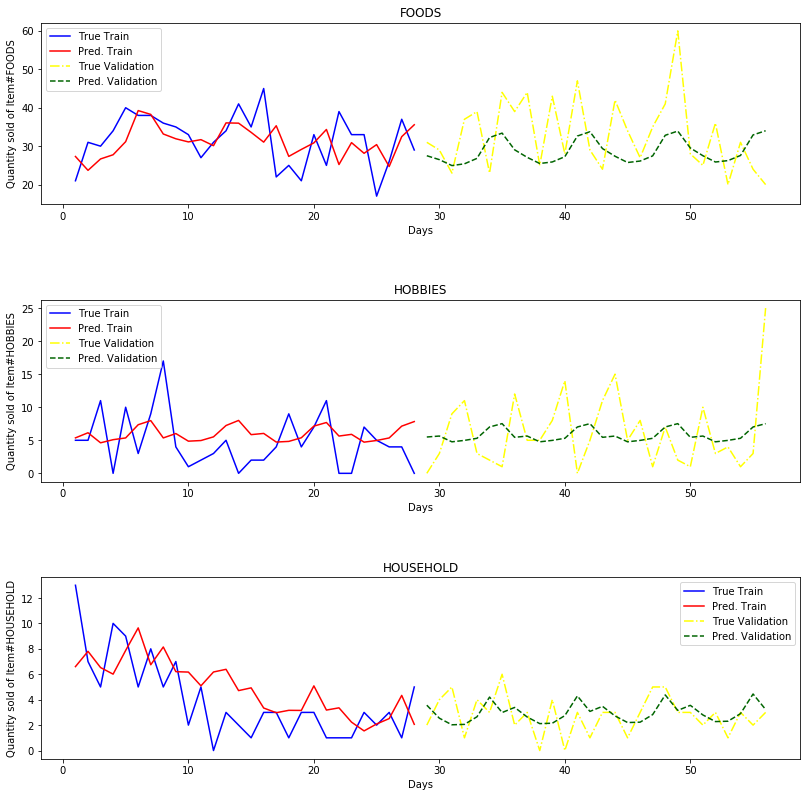

In [376]:
print("Test RMSE for SARIMAX is", get_rmse(cat_sales_val_pred, cat_sales_val))
plot_three_item_pred(["FOODS", "HOBBIES", "HOUSEHOLD"], cat_sales_train, cat_sales_train_pred, cat_sales_val, cat_sales_val_pred, "sarimax_cat")

In [372]:
cat_train_pred_exp, cat_val_pred_exp = exp_fit_predict(cat_sales_train, cat_sales_val)

Test RMSE for ExpSmooth is 7.074952934337891


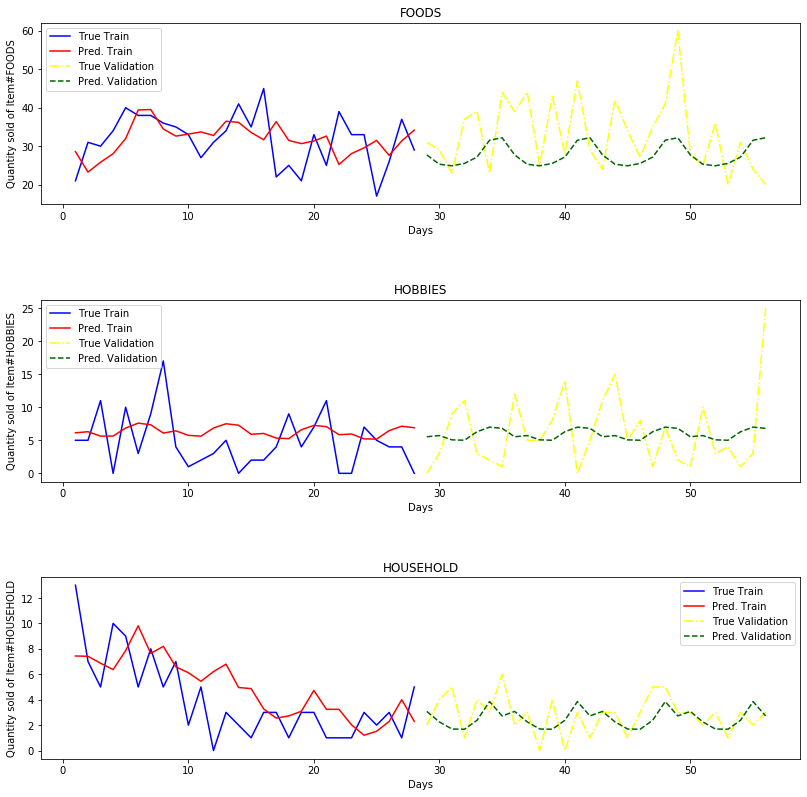

In [375]:
print("Test RMSE for ExpSmooth is", get_rmse(cat_val_pred_exp, cat_sales_val))
plot_three_item_pred(["FOODS", "HOBBIES", "HOUSEHOLD"], cat_sales_train, cat_train_pred_exp, cat_sales_val, cat_val_pred_exp, "exp_sm_cat")

In [374]:
cat_days_train = cat_sales_train.columns
cat_dates_train = calendar.loc[calendar["d"].isin(cat_days_train)]["date"]
cat_train_pred_pro, cat_val_pred_pro = prophet_fit_predict(cat_sales_train, cat_dates_train, cat_sales_val, dates_val)

Test RMSE for ExpSmooth is 6.401089849994144


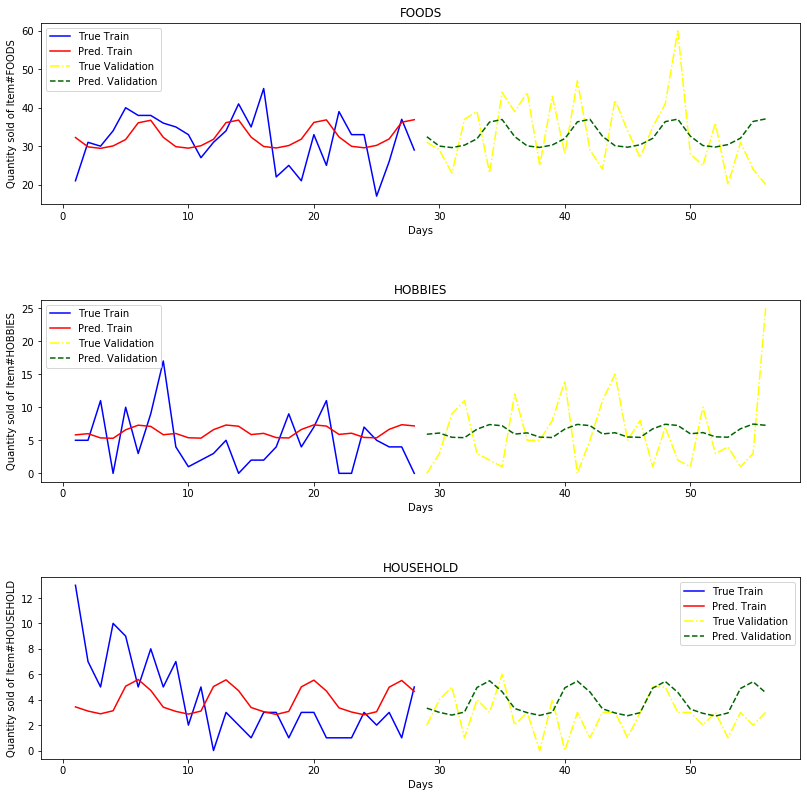

In [377]:
print("Test RMSE for ExpSmooth is", get_rmse(cat_val_pred_pro, cat_sales_val))
plot_three_item_pred(["FOODS", "HOBBIES", "HOUSEHOLD"], cat_sales_train, cat_train_pred_pro, cat_sales_val, cat_val_pred_pro, "pro_cat")

# State-Level Predictions

In [382]:
state_sales = sales_train_val_shuffled.groupby("state_id").sum()
state_sales

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
state_id,,,,,,,,,,,,,,,,,,,,,
CA,11,4,7,8,7,5,8,13,20,2,...,22,25,28,14,17,18,12,21,17,20
TX,2,4,1,13,3,4,0,1,1,1,...,8,12,8,3,5,12,7,4,1,21
WI,0,4,3,5,0,0,2,6,2,6,...,11,16,29,15,15,12,6,10,11,7


In [384]:
state_sales_train = state_sales.iloc[:,:-28]
state_sales_val = state_sales.iloc[:,-28:]

In [385]:
state_sales_train_pred, state_sales_val_pred = arima_fit_predict(state_sales_train, state_sales_val, (0, 1, 1, 7))

Test RMSE for SARIMAX is 5.587117659745814


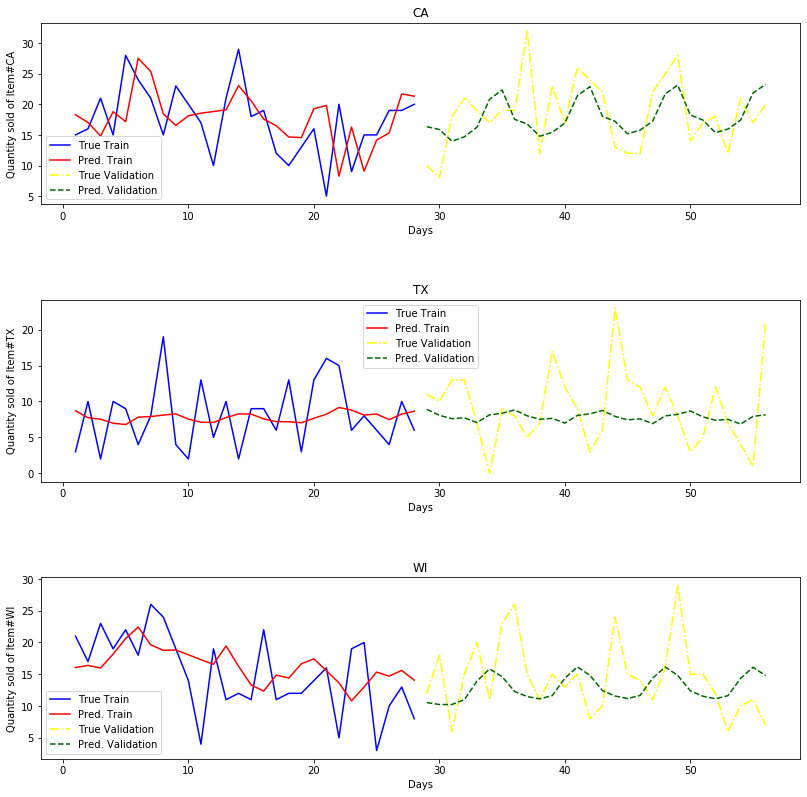

In [387]:
print("Test RMSE for SARIMAX is", get_rmse(state_sales_val_pred, state_sales_val))
plot_three_item_pred(["CA", "TX", "WI"], state_sales_train, state_sales_train_pred, state_sales_val, state_sales_val_pred, "sarimax_state")

In [388]:
state_train_pred_exp, state_val_pred_exp = exp_fit_predict(state_sales_train, state_sales_val)

Test RMSE for ExpSmooth is 5.994117066902863


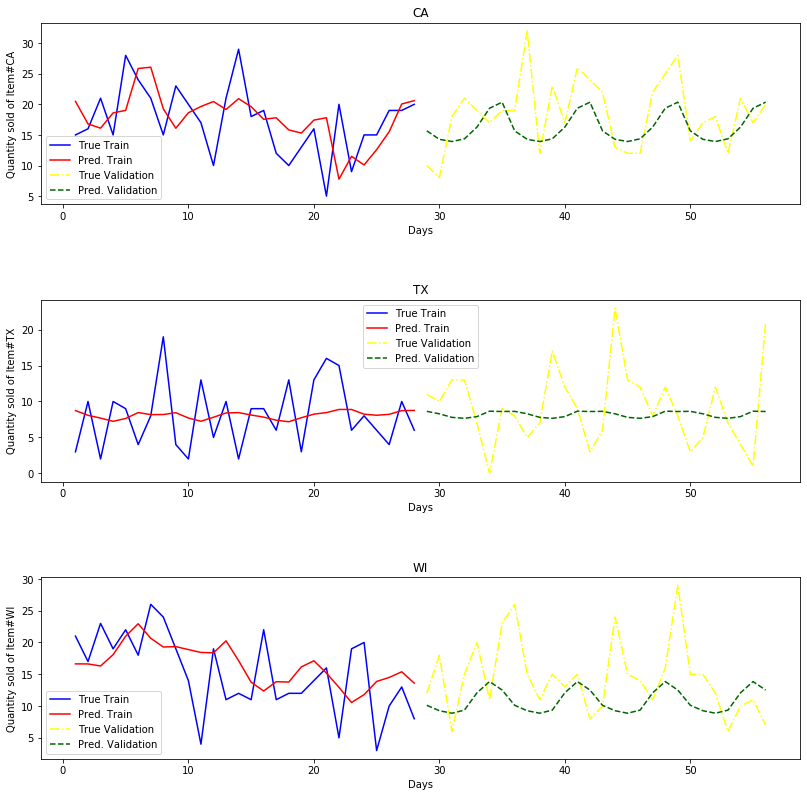

In [389]:
print("Test RMSE for ExpSmooth is", get_rmse(state_val_pred_exp, state_sales_val))
plot_three_item_pred(["CA", "TX", "WI"], state_sales_train, state_train_pred_exp, state_sales_val, state_val_pred_exp, "exp_sm_state")

In [390]:
state_days_train = state_sales_train.columns
state_dates_train = calendar.loc[calendar["d"].isin(state_days_train)]["date"]
state_train_pred_pro, state_val_pred_pro = prophet_fit_predict(state_sales_train, state_dates_train, state_sales_val, dates_val)

Test RMSE for Prophet is 5.491820323131729


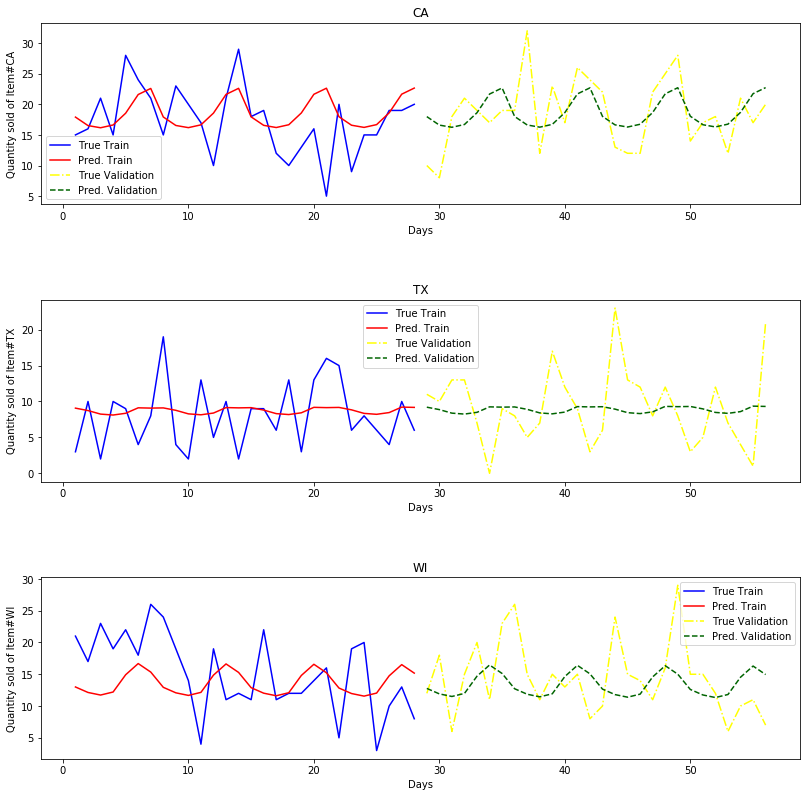

In [391]:
print("Test RMSE for Prophet is", get_rmse(state_val_pred_pro, state_sales_val))
plot_three_item_pred(["CA", "TX", "WI"], state_sales_train, state_train_pred_pro, state_sales_val, state_val_pred_pro, "pro_state")